### Task overview <br>
**Goal**: Practice fine-tuning a pre-trained LM (GPT2-small) on the particular task of commonsense question answering (QA) <br>
**Dataset**: [CommonsenseQA](https://huggingface.co/datasets/tau/commonsense_qa) <br>
**Description** <br>
- Evaluate the performance of the model on testset over training set. <br>
- Monitor: 
    - Whether the model’s performance is improving; 
    - Compare the performance of the base pretrained GPT-2 and the fine-tuned model 
- Steps:
    1. Data preparation. Simiar to [sheet 1.1](https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/01-introduction.html#main-training-data-processing-steps) and [sheet 2.3](https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/02c-MLP-pytorch.html#preparing-the-training-data)
    2. Load the pretrained GPT-2 model
    3. Set up training pipiline. Steps similar to [sheet 2.5](https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/02e-intro-to-hf.html)
    4. Run the training while tracking the losses
    5. Save plot of losses for submission

In [4]:
# pkg preparation
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip3 install accelerate

### Step 1. Data Preparation
1. Acquiring data <br>
2. Minimally exploring dataset <br>
3. Cleaning / wrangling data (combines step 4 from sheet 1.1 and step 1.1 above) <br>
4. Splitting data into training and test set (we will not do any hyperparam tuning) (we don't need further training set wrangling) <br>
5. Tokenizing data and making sure it can be batched (i.e., conversted into 2d tensors), this will also happen in our custom Dataset class (common practice when working with text data) <br>

In [5]:
# downaload dataset from HF
dataset = load_dataset("tau/commonsense_qa")
# inspect dataset, print all keys
print("The keys are:\n", dataset.keys())
# print a sample from the dataset
print("A sample:\n", dataset["train"][0]) # CODE
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# set padding side to be left because we are doing causal LM
tokenizer.padding_side = "left"

The keys are:
 dict_keys(['train', 'validation', 'test'])
A sample:
 {'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}


In [6]:
def massage_input_text(example):
    """
    Helper for converting input examples which have 
    a separate qquestion, labels, answer options
    into a single string.

    Arguments
    ---------
    example: dict
        Sample input from the dataset which contains the 
        question, answer labels (e.g. A, B, C, D),
        the answer options for the question, and which 
        of the answers is correct.
    
    Returns
    -------
    input_text: str
        Formatted training text which contains the question,
        the forwatted answer options (e.g., 'A. <option 1> B. <option 2>' etc)
        and the ground truth answer.
    """
    # combine each label with its corresponding text
    answer_options_list = list(zip(
        example["choices"]["label"],
        example["choices"]["text"]
    ))
    # join each label and text with . and space
    answer_options = " ".join([f"{label}. {text}" for label, text in answer_options_list]) # CODE
    # join the list of options with spaces into single string
    answer_options_string = " ".join(answer_options.split()) # CODE
    # combine question and answer options
    input_text = example["question"] + " " + answer_options_string
    # append the true answer with a new line, "Answer: " and the label
    input_text += "\nAnswer: " + example["answerKey"]

    return input_text

# process input texts of train and test sets
massaged_datasets = dataset.map(
    lambda example: {
        "text": massage_input_text(example)
    }
)

In [7]:
# inspect a sample from our preprocessed data
prep_data_sample = massaged_datasets["train"][0] # CODE, modified
print("A sample from the preprocessed data:\n", prep_data_sample) # CODE, modified

A sample from the preprocessed data:
 {'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A', 'text': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change? A. ignore B. enforce C. authoritarian D. yell at E. avoid\nAnswer: A'}


In [8]:
class CommonsenseQADataset(Dataset):
    """
    Custom dataset class for CommonsenseQA dataset.
    """

    def __init__(
            self, 
            train_split, 
            test_split,
            tokenizer,
            max_length=64,
            dataset_split="train",
        ) -> None:
        """
        Initialize the dataset object.
        
        Arguments
        ---------
        train_split: dict
            Training data dictionary with different columns.
        test_split: dict
            Test data dictionary with different columns.
        tokenizer: Tokenizer
            Initialized tokenizer for processing samples.
        max_length: int
            Maximal length of inputs. All inputs will be 
            truncated or padded to this length.
        dataset_split: str
            Specifies which split of the dataset to use. 
            Default is "train".
        """
        self.train_split = train_split['text']
        self.test_split = test_split['text']
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dataset_split = dataset_split

    def __len__(self):
        """
        Method returning the length of the training dataset.
        """
        return len(self.train_split) if self.dataset_split == "train" else len(self.test_split) # CODE
    
    def __getitem__(self, idx):
        """
        Method returning a single training example.
        Note that it also tokenizes, truncates or pads the input text.
        Further, it creates a mask tensor for the input text which 
        is used for causal masking in the transformer model.

        Arguments
        ---------
        idx: int
            Index of training sample to be retrieved from the data.
        
        Returns
        --------
        tokenized_input: dict
            Dictionary with input_ids (torch.Tensor) and an attention_mask
            (torch.Tensor).
        """
        # retrieve a training sample at the specified index idx
        # HINT: note that this might depend on self.dataset_split
        input_text = self.train_split[idx] if self.dataset_split == "train" else self.test_split[idx] # CODE
        tokenized_input = self.tokenizer(
            input_text,
            max_length = self.max_length, # CODE
            padding = "max_length",
            truncation = True,
            return_tensors = "pt"
        )
        tokenized_input["attention_mask"] = (tokenized_input["input_ids"] != tokenizer.pad_token_id).long()
        return tokenized_input

In [9]:
# move to accelerated device 
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Device: {device}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Device: {device}")
else:
    device = torch.device("cpu")
    print(f"Device: {device}")

Device: cpu


### Step 2. Initialise Model

In [10]:
# load pretrained gpt2 for HF
model = AutoModelForCausalLM.from_pretrained("gpt2") # CODE
# print num of trainable parameters
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f} M parameters")

# Hint: If you run out of memory while trying to run the training, try decreasing the batch size.

GPT-2 size: 124.4 M parameters


### Step 3. Set up configurations required for the training loop

In [11]:
# instantiate dataset with the downloaded commonsense_qa data 
train_dataset = CommonsenseQADataset(
    train_split = massaged_datasets["train"], 
    test_split = massaged_datasets["test"],
    tokenizer = tokenizer,
    max_length = 64, 
    dataset_split = "train" # CODE
)
# instantiate test dataset with the downloaded commonsense_qa data
test_dataset = CommonsenseQADataset(
    train_split = massaged_datasets["train"], 
    test_split = massaged_datasets["test"],
    tokenizer = tokenizer,
    max_length = 64, 
    dataset_split = "test" # CODE
)
# create a DataLoader for the dataset
# the data loader will automatically batch the data
# and iteratively return training examples (question answer pairs) in batches
dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True
)
# create a DataLoader for the test dataset
# reason for separate data loader is that we want to
# be able to use a different index for retreiving the test batches
# we might also want to use a different batch size etc.
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=True
)

### Step 4. Run the training of the model

In [15]:
# Hint: for implementing the forward pass and loss computation, carefully look at the exercise sheets 
# and the links to examples in HF tutorials.

# put the model in training mode
model.train()
# move the model to the device (e.g. GPU)
model = model.to(device)

# trianing configutations 
# feel free to play around with these
epochs  = 1
train_steps =  len(train_dataset) // 32
print("Number of training steps: ", train_steps)
# number of test steps to perform every 10 training steps
# (smaller that the entore test split for reasons of comp. time)
num_test_steps = 5

# define optimizer and learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4) 
# define some variables to accumulate the losses
losses = []
test_losses = []

# iterate over epochs
for e in range(epochs):
    # iterate over training steps
    for i in tqdm(range(train_steps)):
        # get a batch of data
        x = next(iter(dataloader))
        # move the data to the device (GPU)
        x = {key: val.to(device) for key, val in x.items()}  # Move batch to device # CODE

        # forward pass through the model 
        
        outputs = model( 
            input_ids = x["input_ids"],
            attention_mask = x["attention_mask"],
            labels = x["input_ids"]
            # CODE
        )
        # get the loss
        loss = outputs.loss # CODE
        # backward pass
        loss.backward() # CODE
        losses.append(loss.item())
        # update the parameters of the model
        optimizer.step() # CODE

        # zero out gradient for next step
        optimizer.zero_grad() # CODE

        # evaluate on test set every 10 steps
        if i % 10 == 0:
            print(f"Epoch {e}, step {i}, loss {loss.item()}")
            # track test loss for the evaluation iteration
            test_loss = 0
            for j in range(num_test_steps):
                # get test batch
                x_test = next(iter(test_dataloader))
                x_test = x_test.to(device)
                with torch.no_grad():
                    test_outputs = model(
                        input_ids=x_test["input_ids"],
                        attention_mask=x_test["attention_mask"],
                        labels=x_test["input_ids"] # CODE
                    )
                if test_outputs.loss is not None: # Check of the loss is not None
                    test_loss += test_outputs.loss # CODE
                
            test_losses.append(test_loss / num_test_steps)
            print("Test loss: ", test_loss/num_test_steps)

Number of training steps:  304


  0%|                                                   | 0/304 [00:00<?, ?it/s]

Epoch 0, step 0, loss 10.966512680053711


  0%|▏                                        | 1/304 [00:29<2:29:46, 29.66s/it]

Test loss:  tensor(8.0536)


  3%|█▎                                      | 10/304 [02:33<1:09:43, 14.23s/it]

Epoch 0, step 10, loss 2.71817684173584


  4%|█▍                                      | 11/304 [02:58<1:25:33, 17.52s/it]

Test loss:  tensor(2.7612)


  7%|██▋                                     | 20/304 [05:03<1:05:12, 13.78s/it]

Epoch 0, step 20, loss 2.241389751434326


  7%|██▊                                     | 21/304 [05:33<1:27:18, 18.51s/it]

Test loss:  tensor(2.4157)


 10%|████▏                                     | 30/304 [07:27<58:48, 12.88s/it]

Epoch 0, step 30, loss 2.1551876068115234


 10%|████                                    | 31/304 [07:52<1:15:04, 16.50s/it]

Test loss:  tensor(2.1811)


 13%|█████▌                                    | 40/304 [09:48<55:30, 12.61s/it]

Epoch 0, step 40, loss 1.9300326108932495


 13%|█████▍                                  | 41/304 [10:14<1:12:17, 16.49s/it]

Test loss:  tensor(1.9336)


 16%|██████▉                                   | 50/304 [12:11<53:53, 12.73s/it]

Epoch 0, step 50, loss 1.8985474109649658


 17%|██████▋                                 | 51/304 [12:38<1:11:10, 16.88s/it]

Test loss:  tensor(1.9166)


 20%|████████▎                                 | 60/304 [14:29<50:20, 12.38s/it]

Epoch 0, step 60, loss 1.7412619590759277


 20%|████████                                | 61/304 [14:53<1:04:08, 15.84s/it]

Test loss:  tensor(1.8910)


 23%|█████████▋                                | 70/304 [16:45<46:05, 11.82s/it]

Epoch 0, step 70, loss 1.8059301376342773


 23%|█████████▎                              | 71/304 [17:10<1:01:15, 15.78s/it]

Test loss:  tensor(1.8130)


 26%|███████████                               | 80/304 [19:13<46:55, 12.57s/it]

Epoch 0, step 80, loss 1.703949213027954


 27%|███████████▏                              | 81/304 [19:36<58:50, 15.83s/it]

Test loss:  tensor(1.8699)


 30%|████████████▍                             | 90/304 [21:33<49:49, 13.97s/it]

Epoch 0, step 90, loss 1.6837917566299438


 30%|███████████▉                            | 91/304 [22:06<1:08:56, 19.42s/it]

Test loss:  tensor(1.9634)


 33%|█████████████▍                           | 100/304 [24:35<55:57, 16.46s/it]

Epoch 0, step 100, loss 1.6681714057922363


 33%|████████████▉                          | 101/304 [25:07<1:11:25, 21.11s/it]

Test loss:  tensor(1.8773)


 36%|██████████████▊                          | 110/304 [27:27<51:22, 15.89s/it]

Epoch 0, step 110, loss 1.7873094081878662


 37%|██████████████▏                        | 111/304 [27:56<1:03:42, 19.80s/it]

Test loss:  tensor(1.9629)


 39%|████████████████▏                        | 120/304 [30:16<48:06, 15.69s/it]

Epoch 0, step 120, loss 1.5906360149383545


 40%|████████████████▎                        | 121/304 [30:45<59:15, 19.43s/it]

Test loss:  tensor(1.7972)


 43%|█████████████████▌                       | 130/304 [33:23<50:10, 17.30s/it]

Epoch 0, step 130, loss 1.6256121397018433


 43%|████████████████▊                      | 131/304 [33:57<1:04:01, 22.21s/it]

Test loss:  tensor(1.8323)


 46%|██████████████████▉                      | 140/304 [36:22<45:23, 16.61s/it]

Epoch 0, step 140, loss 1.6109676361083984


 46%|███████████████████                      | 141/304 [36:52<55:52, 20.57s/it]

Test loss:  tensor(1.7801)


 49%|████████████████████▏                    | 150/304 [39:02<36:44, 14.31s/it]

Epoch 0, step 150, loss 1.6622003316879272


 50%|████████████████████▎                    | 151/304 [39:28<45:30, 17.84s/it]

Test loss:  tensor(1.7585)


 53%|█████████████████████▌                   | 160/304 [41:47<34:37, 14.43s/it]

Epoch 0, step 160, loss 1.7394182682037354


 53%|█████████████████████▋                   | 161/304 [42:15<44:07, 18.51s/it]

Test loss:  tensor(1.9057)


 56%|██████████████████████▉                  | 170/304 [44:12<28:15, 12.65s/it]

Epoch 0, step 170, loss 1.7609511613845825


 56%|███████████████████████                  | 171/304 [44:37<36:23, 16.42s/it]

Test loss:  tensor(1.8741)


 59%|████████████████████████▎                | 180/304 [46:24<23:37, 11.43s/it]

Epoch 0, step 180, loss 1.6382803916931152


 60%|████████████████████████▍                | 181/304 [46:48<31:26, 15.34s/it]

Test loss:  tensor(1.8300)


 62%|█████████████████████████▋               | 190/304 [48:53<24:11, 12.73s/it]

Epoch 0, step 190, loss 1.550491452217102


 63%|█████████████████████████▊               | 191/304 [49:17<30:28, 16.18s/it]

Test loss:  tensor(1.7962)


 66%|██████████████████████████▉              | 200/304 [51:13<23:41, 13.67s/it]

Epoch 0, step 200, loss 1.6100095510482788


 66%|███████████████████████████              | 201/304 [51:51<35:48, 20.86s/it]

Test loss:  tensor(1.7868)


 69%|████████████████████████████▎            | 210/304 [53:54<20:47, 13.27s/it]

Epoch 0, step 210, loss 1.4915876388549805


 69%|████████████████████████████▍            | 211/304 [54:23<28:06, 18.13s/it]

Test loss:  tensor(1.7446)


 72%|█████████████████████████████▋           | 220/304 [56:12<17:09, 12.26s/it]

Epoch 0, step 220, loss 1.4172223806381226


 73%|█████████████████████████████▊           | 221/304 [56:36<21:49, 15.78s/it]

Test loss:  tensor(1.7829)


 76%|███████████████████████████████          | 230/304 [58:31<15:43, 12.75s/it]

Epoch 0, step 230, loss 1.4164819717407227


 76%|███████████████████████████████▏         | 231/304 [58:58<20:58, 17.24s/it]

Test loss:  tensor(1.7607)


 79%|██████████████████████████████▊        | 240/304 [1:00:54<13:57, 13.08s/it]

Epoch 0, step 240, loss 1.5902371406555176


 79%|██████████████████████████████▉        | 241/304 [1:01:19<17:23, 16.57s/it]

Test loss:  tensor(1.7540)


 82%|████████████████████████████████       | 250/304 [1:03:23<12:52, 14.30s/it]

Epoch 0, step 250, loss 1.5085529088974


 83%|████████████████████████████████▏      | 251/304 [1:03:47<15:10, 17.17s/it]

Test loss:  tensor(1.7743)


 86%|█████████████████████████████████▎     | 260/304 [1:05:39<08:40, 11.84s/it]

Epoch 0, step 260, loss 1.4384350776672363


 86%|█████████████████████████████████▍     | 261/304 [1:06:05<11:31, 16.08s/it]

Test loss:  tensor(1.7543)


 89%|██████████████████████████████████▋    | 270/304 [1:07:55<07:03, 12.45s/it]

Epoch 0, step 270, loss 1.541365146636963


 89%|██████████████████████████████████▊    | 271/304 [1:08:21<09:06, 16.57s/it]

Test loss:  tensor(1.7229)


 92%|███████████████████████████████████▉   | 280/304 [1:10:13<04:59, 12.47s/it]

Epoch 0, step 280, loss 1.4068559408187866


 92%|████████████████████████████████████   | 281/304 [1:10:37<06:07, 15.96s/it]

Test loss:  tensor(1.7721)


 95%|█████████████████████████████████████▏ | 290/304 [1:12:38<03:03, 13.10s/it]

Epoch 0, step 290, loss 1.50174081325531


 96%|█████████████████████████████████████▎ | 291/304 [1:13:02<03:35, 16.57s/it]

Test loss:  tensor(1.7405)


 99%|██████████████████████████████████████▍| 300/304 [1:14:48<00:47, 11.89s/it]

Epoch 0, step 300, loss 1.4545259475708008


 99%|██████████████████████████████████████▌| 301/304 [1:15:13<00:47, 15.87s/it]

Test loss:  tensor(1.7485)


100%|███████████████████████████████████████| 304/304 [1:15:50<00:00, 14.97s/it]


### Step 5. Plot the fine-tuning loss and MAKE SURE TO SAVE IT AND SUBMIT IT

Text(0, 0.5, 'Loss')

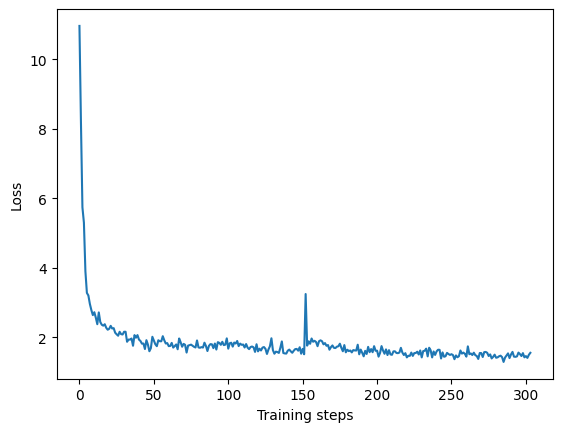

In [16]:
# plot training losses on x axis
plt.plot(losses) # CODE
plt.xlabel("Training steps")
plt.ylabel("Loss")

In [17]:
# print a few predictions on the eval dataset to see what the model predicts

# construct a list of questions without the ground truth label
# and compare prediction of the model with the ground truth

def construct_test_samples(example):
    """
    Helper for converting input examples which have 
    a separate qquestion, labels, answer options
    into a single string for testing the model.

    Arguments
    ---------
    example: dict
        Sample input from the dataset which contains the 
        question, answer labels (e.g. A, B, C, D),
        the answer options for the question, and which 
        of the answers is correct.
    
    Returns
    -------
    input_text: str, str
        Tuple: Formatted test text which contains the question,
        the forwatted answer options (e.g., 'A. <option 1> B. <option 2>' etc); 
        the ground truth answer label only.
    """

    answer_options_list = list(zip(
        example["choices"]["label"],
        example["choices"]["text"]
    ))
    # join each label and text with . and space
    answer_options = " ".join([f"{label}.{text}" for label, text in answer_options_list]) # CODE
    # join the list of options with spaces into single string
    answer_options_string = " ".join(answer_options.split()) # CODE
    # combine question and answer options
    input_text = example["question"] + " " + answer_options_string
    # create the test input text which should be:
    # the input text, followed by the string "Answer: "
    # we don't need to append the ground truth answer since we are creating test inputs
    # and the answer should be predicted.
    input_text += "\nAnswer: " # CODE

    return input_text, example["answerKey"]

test_samples = [construct_test_samples(dataset["validation"][i]) for i in range(10)]
test_samples

[('A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A.bank B.library C.department store D.mall E.new york\nAnswer: ',
  'A'),
 ('What do people aim to do at work? A.complete job B.learn from each other C.kill animals D.wear hats E.talk to each other\nAnswer: ',
  'A'),
 ('Where would you find magazines along side many other printed works? A.doctor B.bookstore C.market D.train station E.mortuary\nAnswer: ',
  'B'),
 ('Where are  you likely to find a hamburger? A.fast food restaurant B.pizza C.ground up dead cows D.mouth E.cow carcus\nAnswer: ',
  'A'),
 ('James was looking for a good place to buy farmland.  Where might he look? A.midwest B.countryside C.estate D.farming areas E.illinois\nAnswer: ',
  'A'),
 ('What island country is ferret popular? A.own home B.north carolina C.great britain D.hutch E.outdoors\nAnswer: ',
  'C'),
 ("In what Spanish speaking North American country can you get a great cup of coffee? A.mildred's co

### One More Step: Test the model 

In [18]:
# set it to evaluation mode
model.eval()

predictions = []
for sample in test_samples:
    input_text = sample[0]
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    output = model.generate(
        input_ids.input_ids,
        attention_mask = input_ids.attention_mask,
        max_new_tokens=2,
        do_sample=True,
        temperature=0.4,
    )
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append((input_text, prediction, sample[1]))

print("Predictions of trained model ", predictions)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predictions of trained model  [('A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A.bank B.library C.department store D.mall E.new york\nAnswer: ', 'A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A.bank B.library C.department store D.mall E.new york\nAnswer:  B.', 'A'), ('What do people aim to do at work? A.complete job B.learn from each other C.kill animals D.wear hats E.talk to each other\nAnswer: ', 'What do people aim to do at work? A.complete job B.learn from each other C.kill animals D.wear hats E.talk to each other\nAnswer:  Sarah', 'A'), ('Where would you find magazines along side many other printed works? A.doctor B.bookstore C.market D.train station E.mortuary\nAnswer: ', 'Where would you find magazines along side many other printed works? A.doctor B.bookstore C.market D.train station E.mortuary\nAnswer:  Where would', 'B'), ('Where are  you likely to find